# FIRST PART

In [219]:
import pandas as pd
import numpy as np
import json

def pivot(df):
    return df.pivot(index=['Area', 'Year', 'Item'], columns='Element', values=['Value'])


data = pd.read_csv('models/Hermen/data/FBS.csv')

df = data[(data.Area=='Hungary') & (data.Year == 2017)].reset_index(drop=True)

In [220]:
FAO_to_GGI_code = {
    'Food supply (kcal/capita/day)': 'FDKCi',
    'Food supply quantity (kg/capita/yr)': 'FDKGi',
    'Production': 'FPi',
    'Seed': 'SDi',
    'Feed': 'FDi',
    'Processing': 'PDi',
    'Residuals': 'RDi',
    'Import Quantity': 'FIi',
    'Export Quantity': 'FEi',
    'Other uses (non-food)': 'NFDi',
    'Losses': 'FLOi',
    'Stock Variation': 'SVi',
    'Food': 'Food',
    'Domestic supply quantity': 'Domestic supply quantity',
    
}

df['GGI_code'] = df['Element'].apply(lambda x: FAO_to_GGI_code[x])

df.loc[df.GGI_code == 'FDKGi', 'Value'] = df.loc[df.GGI_code == 'FDKGi', 'Value'] / 365
df.loc[df.GGI_code == 'FDKGi', 'Unit']  = 'kg/capita/day'

In [221]:

def pivot(df):
    return df.pivot(index=['Item'], columns='GGI_code', values='Value')

df = pivot(df).fillna(0)

In [222]:
X = {}
for code in df.columns:
    X[code] = df[code]
    
X['P'] = 9729822
X['FWPPi'] = 0.5
X['FWCRi'] = 0
X['FDi_baseline'] = X['FDi']

In [223]:
from graphmodels.utils import parse_parameter_json

parameters = parse_parameter_json("models/Hermen/LandUse_parameters.json")

X['FCRi'] = pd.Series([25, 6.4, 3.003, 2.3, 0.7, 15], index=['Bovine Meat', 'Pigmeat', 'Poultry Meat', 'Eggs', 'Milk - Excluding Butter', 'Meat, Other'])
X['LUi'] = parameters["LUi"]
X['CYi'] = parameters["CYi"]

In [224]:
from models.Hermen.LandUseModel import LandUseModel

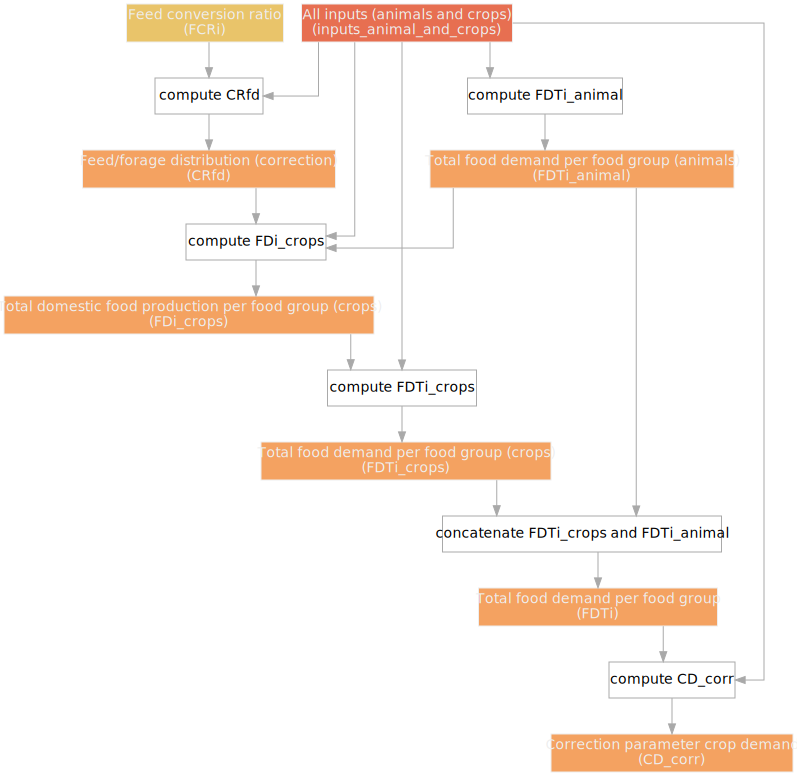

In [225]:
LandUseModel.draw()

In [229]:
FDTi_crops = LandUseModel.run(X)['FDTi_crops'] 

In [230]:
def test_variables_in_model(model, output, X):
    for var, value in X.items():
        cd_corr_1 = model.run(X)[output]
        X_bis = X.copy()
        X_bis[var] = -1e4 * X_bis[var]**2 + 10000
        cd_corr_2 = model.run(X_bis)[output]

        if (cd_corr_1 - cd_corr_2).sum() == 0:
            print(var)

test_variables_in_model(LandUseModel, 'CD_corr', X)

Domestic supply quantity
FDKCi
Food
FDi_baseline
FCRi


In [231]:
# from models.Hermen.model_crop_demand_correction import CD_corr_model
# from models.Hermen.model_food_demand_total import FDTi_model

# Second part

In [282]:
data = pd.read_csv('models/Hermen/data/QC.csv')
df = data[(data.Area=='Hungary') & (data.Year == 2017)].reset_index(drop=True)
def pivot(df):
    return df.pivot(index=['Area', 'Year', 'Item'], columns='Element', values=['Value'])
pivot(data)

Value             \
Element                                           Area harvested Production   
Area        Year Item                                                         
Afghanistan 1961 Anise, badian, fennel, coriander            NaN        NaN   
                 Apples                                   2220.0    15100.0   
                 Apricots                                 4820.0    32000.0   
                 Barley                                 350000.0   378000.0   
                 Berries nes                              6800.0    60000.0   
...                                                          ...        ...   
Zimbabwe    2019 Vanilla                                    20.0        9.0   
                 Vegetables Primary                      35994.0   241666.0   
                 Vegetables, fresh nes                   28348.0   194117.0   
                 Vegetables, leguminous nes                171.0      857.0   
                 Wheat                                   50342.0    80000.0   

                                                            
Element                                              Yield  
Area        Year Item                                       
Afghanistan 1961 Anise, badian, fennel, coriander      NaN  
                 Apples                            68018.0  
                 Apricots                          66390.0  
                 Barley                            10800.0  
                 Berries nes                       88235.0  
...                                                    ...  
Zimbabwe    2019 Vanilla                            4500.0  
                 Vegetables Primary                67141.0  
                 Vegetables, fresh nes             68476.0  
                 Vegetables, leguminous nes        50117.0  
                 Wheat                             15891.0  

[634107 rows x 3 columns]

In [283]:
FAO_to_GGI_code = {
    'Area harvested': 'TCLDi',
    'Yield': 'CYi',
    'Production': 'TCLD_baseline'
}

df['GGI_code'] = df['Element'].apply(lambda x: FAO_to_GGI_code[x])


def pivot(df):
    return df.pivot(index=['Item'], columns='GGI_code', values='Value')

df = pivot(df).fillna(0)

In [316]:
df.loc['Cereals, Total']

GGI_code
CYi                 58355.0
TCLD_baseline    14017280.0
TCLDi             2402083.0
Name: Cereals, Total, dtype: float64

In [298]:
X = {}
for code in df.columns:
    X[code] = df[code]
    
X['CD_corr'] = 1.16
X['FDTi_crops'] = FDTi_crops
X['TCLD_baseline'] = X['TCLD_baseline'].sum()

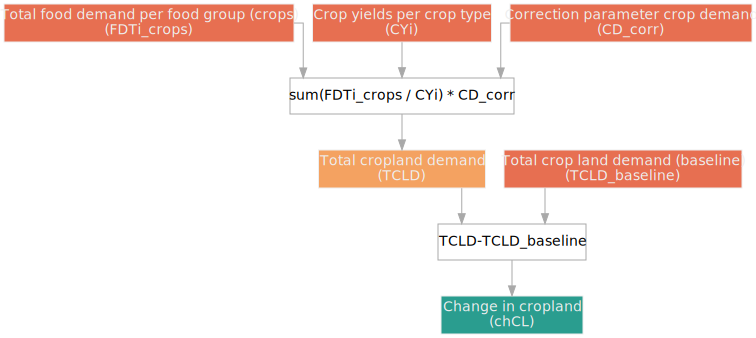

In [299]:
from graphmodels.graphmodel import GraphModel
# this crop group excludes the 'processed' foods: 'Sugar & Sweeteners', 'Vegetable Oils', 'Stimulants', 'Spices', 'Alcoholic Beverages' for now
# in my model 'fibre crops' is added as a constant variable (based on 2017 land use data), as it's not in the food-demand vector we need to add it manually
#'Fibre Crops Primary'
Crop_group2 = ['Cereals - Excluding Beer', 'Fruits - Excluding Wine', 'Oilcrops',
               'Pulses', 'Starchy Roots', 'Sugar Crops', 'Treenuts', 'Vegetables']

chCL_nodes = [

    # this is the value that is computed with the addition of animal feed (so the CRfd part)
    {'type': 'input',
     'id': 'FDTi_crops',
     'name': 'Total food demand per food group (crops)',
     'unit': 'x 1000 tonne',
     },
    {'type': 'input',
     'unit': 'hg/ha',
     'id': 'CYi',
     'name': 'Crop yields per crop type',
     },
    # this was TCL2017i
    {'type': 'input',
     'unit': 'ha',
     'id': 'TCLD_baseline',
     'name': 'Total crop land demand (baseline)',
     },
    {'type': 'input',
     'unit': 'ha',
     'id': 'CD_corr',
     'name': 'Correction parameter crop demand',
     },
    {'type': 'variable',
     'id': 'TCLD',
     'name': 'Total cropland demand',
     'unit': 'x 1000ha',
     'in': ['FDTi_crops', 'CYi', 'CD_corr'],
     'computation': {'name': 'sum(FDTi_crops / CYi) * CD_corr',
                     'formula': lambda X: (X['FDTi_crops']/X['CYi']).sum()  * X['CD_corr']}
     },
    {'type': 'output',
     'id': 'chCL',
     'name': 'Change in cropland',
     'unit': 'x 1000ha',
     'in': ['TCLD', 'TCLD_baseline'],
     'computation': {'name': 'TCLD-TCLD_baseline',
                     'formula': lambda X: (X['TCLD'] - X['TCLD_baseline'])}
     }
]

chCL_model = GraphModel(chCL_nodes)

chCL_model.draw()


In [306]:
chCL_model.run(X)['TCLD']

0.12791235233040557

In [310]:
(X['CYi'] * X['FDTi_crops']).dropna()

Item
Oilcrops    8.954736e+07
dtype: float64

In [312]:
X['CYi']

Item
Almonds, with shell                   4810.0
Anise, badian, fennel, coriander     16088.0
Apples                              147255.0
Apricots                             48483.0
Asparagus                            35539.0
                                      ...   
Vegetables, fresh nes               153108.0
Vetches                               4800.0
Walnuts, with shell                  15557.0
Watermelons                         344997.0
Wheat                                54287.0
Name: CYi, Length: 96, dtype: float64